In [706]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

In [707]:
# DEMO = False
# WRITE_ERRORS_TO_FILE = True

In [708]:

# if DEMO:
#     CHARTEVENTS_BY_ICUSTAY_ID = 'data_demo/parquet/'
#     REDUCED_CE_BY_ICUSTAY_ID = 'data_demo/samples/'
#     NUMERICAL_BY_ICUSTAY_ID = 'data_demo/samples_numerical/'
#     STATB_BY_ICUSTAY_ID = 'data_demo/samples_statB/'
#     STATB_CSV_BY_ICUSTAY_ID = 'data_demo/samples_statB_csv/'
# else:

CHARTEVENTS_BY_ICUSTAY_ID = 'data/parquet/'
REDUCED_CE_BY_ICUSTAY_ID = 'data/samples/'
NUMERICAL_BY_ICUSTAY_ID = 'data/samples_numerical/'
STATB_BY_ICUSTAY_ID = 'data/samples_statB/'
DEMO_BY_ICUSTAY_ID = 'data/samples_demographics/'
ICD9_BY_ICUSTAY_ID = 'data/samples_icd9/'
CHARTEVENTS_FILENAME = 'mimic-iii/CHARTEVENTS.csv'
DIAGNOSES_FILENAME = 'mimic-iii/DIAGNOSES_ICD.csv'
READMISSION_FILENAME = 'data/readmission.csv'
EMBEDDED_FILENAME = 'resources/embedded.parquet'
ANNOTATION_FILENAME = 'data/anotation.csv'
STEP_FAIL_FILE = 'Step9_failed.txt'
BASELINE_FILENAME = 'data/baseline_data.csv'


In [709]:
K_FOLDS = 5
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.5
RANDOM_STATE = 1234
EPOCH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
BETA = 0.9

In [710]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize,dtype=float)
        #self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [711]:
def reset_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

In [712]:
class ReadmissionDataset(Dataset):
    def __init__(self, annotations_file, numerical_dir=None, statB_dir=None, icd9_dir=None, demo_dir=None):
        self.labels = pd.read_csv(annotations_file)
        self.numerical_dir = numerical_dir
        self.statB_dir = statB_dir
        self.icd9_dir = icd9_dir
        self.demo_dir = demo_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.numerical_dir:
            numerical_path = os.path.join(self.numerical_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            data = pd.read_parquet(numerical_path).to_numpy()
        if self.statB_dir:
            statB_path = os.path.join(self.statB_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            data = pd.read_parquet(statB_path).to_numpy().reshape(1,-1)
            # assert data.shape[1] == 29, f'Stay = {self.labels.iloc[idx, 0]}'
        if self.icd9_dir:
            icd9_path = os.path.join(self.icd9_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            icd9 = pd.read_parquet(icd9_path).reset_index(drop=True).to_numpy()
            #if self.numerical_dir:
            icd9 = np.vstack([icd9]*data.shape[0])
            data = np.hstack([data, icd9]) 
            # assert icd9.shape[1] == 300, f'Stay = {self.labels.iloc[idx, 0]}'
        if self.demo_dir:
            demo_path = os.path.join(self.demo_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            demo = pd.read_parquet(demo_path).reset_index(drop=True).to_numpy()
            #if self.numerical_dir:
            demo = np.vstack([demo]*data.shape[0])
            data = np.hstack([data, demo])
            # assert demo.shape[1] == 4, f'Stay = {self.labels.iloc[idx, 0]}'

        #data = torch.from_numpy(data.astype(float))
        data = data.astype(float)
        label = np.ndarray((1,1))
        label[0,0] = self.labels.iloc[idx, 1]
        
        return data, label

In [713]:
class BaselineReadmissionDataset(Dataset):
    def __init__(self, baseline_file):
        self.baseline_file = baseline_file
        self.dataframe = pd.read_csv(self.baseline_file)
        self.labels = self.dataframe['READMISSION'].to_numpy().reshape(-1,1)
        # print(self.labels)
        self.data = self.dataframe.iloc[:,1:].to_numpy(dtype=np.float64,na_value=0.0)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = torch.from_numpy(self.data[idx,:])
        label = torch.from_numpy(self.labels[idx].astype(np.float64))

        return data, label

In [714]:
dataset = BaselineReadmissionDataset(BASELINE_FILENAME)

In [715]:
train_dataset, remaining = train_test_split(dataset, train_size=TRAIN_SPLIT, random_state=RANDOM_STATE,shuffle=False)
valid_dataset, test_dataset = train_test_split(remaining, test_size=TEST_SPLIT, random_state=RANDOM_STATE,shuffle=False)

In [716]:
model = linearRegression(len(dataset[0][0]), 1)
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [717]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [718]:
def getMetrics(dataloader, model):
    with torch.no_grad():
        loss = 0.0
        y_predict = []
        y_actual = []
        y_score = []
        for i, (x_input, label) in enumerate(dataloader):
        # Calculating the loss and accuracy for the test dataset

            predicted = torch.squeeze(model(torch.nan_to_num(x_input)))
            
            if hasattr(predicted.tolist(),'__len__'):
                y_score.extend(predicted.tolist())
                y_predict.extend(torch.round(predicted).tolist())
            else:
                y_score.append(predicted.tolist())
                y_predict.append(torch.round(predicted).tolist())

            if hasattr(torch.squeeze(label).tolist(),'__len__'):
                # print(label)
                y_actual.extend(torch.round(torch.squeeze(label)).tolist())
            else:
                y_actual.append(torch.round(torch.squeeze(label)).tolist())


        precision = metrics.precision_score(y_actual,y_predict)
        accuracy = metrics.accuracy_score(y_actual,y_predict)
        recall = metrics.recall_score(y_actual,y_predict)
        auc = metrics.roc_auc_score(y_actual, y_score)


        
    return precision, accuracy, recall, auc

In [719]:
def rocCurve(dataloader, model):
    with torch.no_grad():
        loss = 0.0
        y_predict = []
        y_actual = []
        y_score = []
        for i, (x_input, label) in enumerate(dataloader):
        # Calculating the loss and accuracy for the test dataset


            

            predicted = torch.squeeze(model(torch.nan_to_num(x_input)))
            y_score.extend(predicted.tolist())
            y_predict.extend(torch.round(predicted).tolist())
            y_actual.extend(torch.round(torch.squeeze(label)).tolist())


        precision = metrics.precision_score(y_actual,y_predict)
        accuracy = metrics.accuracy_score(y_actual,y_predict)
        recall = metrics.recall_score(y_actual,y_predict)
        auc = metrics.roc_auc_score(y_actual, y_score)

        '''Example
        import matplotlib.pyplot as plt
        from sklearn.datasets import make_classification
        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_predictions(y_test, y_pred)
        plt.show()
        '''
        #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions
        # Should produce same as below


        fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_score)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()
        
        
    return precision, accuracy, recall, auc

In [720]:

loss_list = []
losses_train =[]
losses_valid = []
acc_train = []
acc_valid = []


for epoch in range(EPOCH):
    current_loss = 0.0
    for i, (x_input, y_actual) in enumerate(train_dataloader):

        optimizer.zero_grad()
        y_predict = model(torch.nan_to_num(x_input))
        loss = criterion(y_predict, y_actual)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
    
    
    losses_train.append(current_loss / len(train_dataloader))
    pr, ac, rc, auc = getMetrics(train_dataloader, model)
    acc_train.append(ac)
    
    print('Epoch: {}. Training \tLoss: {:.4f}. \tAcc: {:.4f}'.format(epoch, (current_loss / len(train_dataloader)), ac))

    
    pr, ac, rc, auc = getMetrics(valid_dataloader, model)
    acc_valid.append(ac)
    print('Epoch: {}. Validation \t\t\tAcc: {:.4f}'.format(epoch, ac))
        
    
    

Epoch: 0. Training 	Loss: 0.5459. 	Acc: 0.8068
Epoch: 0. Validation 			Acc: 0.8070
Epoch: 1. Training 	Loss: 0.4778. 	Acc: 0.8081
Epoch: 1. Validation 			Acc: 0.8081
Epoch: 2. Training 	Loss: 0.4711. 	Acc: 0.8086
Epoch: 2. Validation 			Acc: 0.8087
Epoch: 3. Training 	Loss: 0.4668. 	Acc: 0.8092
Epoch: 3. Validation 			Acc: 0.8091
Epoch: 4. Training 	Loss: 0.4633. 	Acc: 0.8093
Epoch: 4. Validation 			Acc: 0.8097
Epoch: 5. Training 	Loss: 0.4607. 	Acc: 0.8096
Epoch: 5. Validation 			Acc: 0.8104
Epoch: 6. Training 	Loss: 0.4585. 	Acc: 0.8101
Epoch: 6. Validation 			Acc: 0.8106
Epoch: 7. Training 	Loss: 0.4576. 	Acc: 0.8104
Epoch: 7. Validation 			Acc: 0.8097
Epoch: 8. Training 	Loss: 0.4559. 	Acc: 0.8106
Epoch: 8. Validation 			Acc: 0.8102
Epoch: 9. Training 	Loss: 0.4547. 	Acc: 0.8107
Epoch: 9. Validation 			Acc: 0.8110
Epoch: 10. Training 	Loss: 0.4535. 	Acc: 0.8109
Epoch: 10. Validation 			Acc: 0.8110
Epoch: 11. Training 	Loss: 0.4525. 	Acc: 0.8110
Epoch: 11. Validation 			Acc: 0.8114


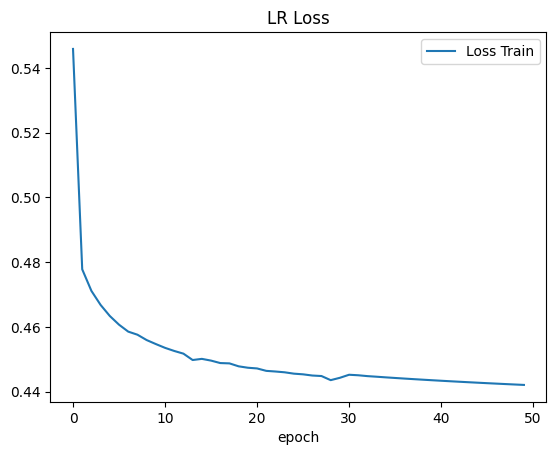

In [722]:
plt.plot(losses_train, label='Loss Train')
plt.xlabel('epoch')
plt.title('LR Loss')
plt.legend()
plt.show()

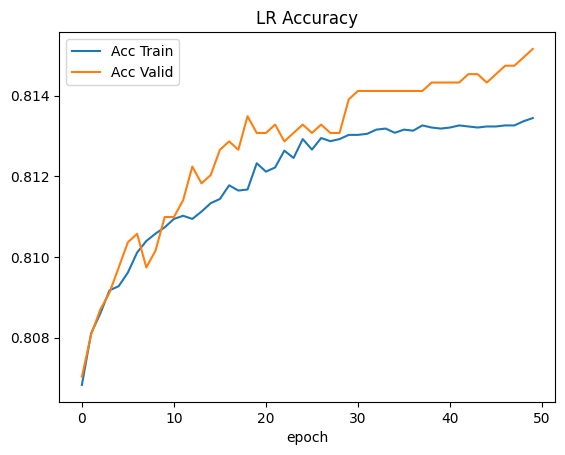

In [723]:
plt.plot(acc_train, label='Acc Train')
plt.plot(acc_valid, label='Acc Valid')
plt.xlabel('epoch')
plt.title('LR Accuracy')
plt.legend()
plt.show()

In [724]:

pr, ac, rc, auc = getMetrics(test_dataloader, model)
print('Testing Metrics: \nPrecision: \t{:.4f} \nAccuracy: \t{:.4f} \nRecall: \t{:.4f} \nAUC: \t\t{:.4f}'.format(pr, ac, rc, auc))

Testing Metrics: 
Precision: 	0.6354 
Accuracy: 	0.8225 
Recall: 	0.0694 
AUC: 		0.7516
